### Part 2:  Pose Graph Optimization for 2D SLAM

### Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

### Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:

1. Initial position
2. Odometry Contraints/Edges: This "edge" information tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges: Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` (in `data/`) which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://saishubodh.notion.site/G2O-Edge-Types-d9f9ff63c77c4ceeb84b1e49085004e3) ). The ground truth is `gt.txt`.

In [38]:
import sys
sys.path.append("..")
import open3d as o3d
import numpy as np
from matplotlib import pyplot as plt
from misc import g2o_to_kitti as g2o



# import g2opy as g2o

## Steps:



### Part 1

Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.

If you plot the initialized poses using odometry information, you need to get as the right plot below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](../misc/robot-poses-MR-P1.png)

(Use `draw()` helper function or `g2o_viewer` or `EVO`)

### Part 2



Now calculate the residual and the Jacobian and update your parameters using LM.

Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster. You can also visualise your Jacobian and see the structure of the matrix (just use `plt.imshow`).

**Regarding LM iterations, stopping criterion, information matrix values.**

1. As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notes on non-linear LS)](https://saishubodh.notion.site/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).

2. You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

3. You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this assignment. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (seen later on), you will be getting a close to ground truth trajectory.

**Tip**

Be sure to make your code modular and implement this in various stages. It will help you debug errors. Feel free to create helper functions in other files, just be sure to submit those as well. 

You are free to optimise your code using numba/Jax/torch if you wish, just ensure that you are not using any built in functions for any of the steps. It is only compulsory to verify your Jacobian using Jax.

## Main

In [50]:
def readVertex(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    x_arr = []
    y_arr = []
    theta_arr = []

    for line in A:
        if "VERTEX_SE2" in line:
            (ver, ind, x, y, theta) = line.split()
            x_arr.append(float(x))
            y_arr.append(float(y))
            theta_arr.append(float(theta.rstrip('\n')))

    return np.array([x_arr, y_arr, theta_arr])

def readEdge(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    ind1_arr = []
    ind2_arr = []
    del_x = []
    del_y = []
    del_theta = []
    
    matrix = []

    for line in A:
        if "EDGE_SE2" in line:
            (edge, ind1, ind2, dx, dy, dtheta, i1, i2, i3, i4, i5, i6) = line.split()
            ind1_arr.append(int(ind1))
            ind2_arr.append(int(ind2))
            del_x.append(float(dx))
            del_y.append(float(dy))
            del_theta.append(float(dtheta))
            

            matrix.append(np.array([[i1, i2, i3], [i2, i4, i5], [i3, i5, i6]]).astype(np.float32))
            
    # Returns M (matrix), E stuff
    return np.array(matrix), np.array( ind1_arr), np.array(ind2_arr), np.array(del_x), np.array(del_y), np.array(del_theta)

In [5]:

X, Y, T = readVertex("../data/edges.txt")
I, i1, i2, dX, dY, dT = readEdge("../data/edges.txt")
print(X, Y, T)
print(I.shape)

# print(i1, i2)

-5.0 -8.0 0.0
(139, 3, 3)


#### Initial Graph Construction

In [40]:
def constructGraph(X, Y, T, dX, dY, dT):
    '''
    Input: 
        X: Initial X
        Y: Initial Y
        T: Initial Theta
        dX: delta X in Constraint
        dY: delta Y in Constraint
        dT: delta Theta in Constraint
        
    Output:
        Graph created from observations
    '''
    length = dX.shape[0]
    xCurr = X
    yCurr = Y
    tCurr = T
    graph = [[xCurr, yCurr, tCurr]]
    
    for constraintIndex in range(length):
        xNext = xCurr + dX[constraintIndex] * np.cos(tCurr) - dY[constraintIndex] * np.sin(tCurr)
        yNext = yCurr + dX[constraintIndex] * np.sin(tCurr) + dY[constraintIndex] * np.cos(tCurr)
        tNext = tCurr + dT[constraintIndex]
        
        graph.append([xNext, yNext, tNext])
        xCurr, yCurr, tCurr = xNext, yNext, tNext
    return np.array(graph).squeeze() - np.array([X, Y, T]).squeeze()



Writing to a file

Initial Point ( -5.0 -8.0 0.0 )
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
graph shape (121, 3)


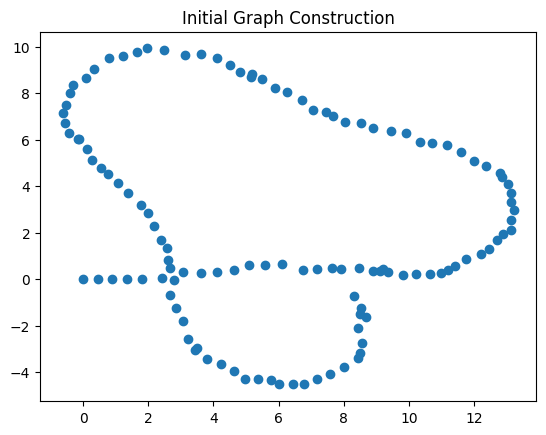

In [41]:
X, Y, T = readVertex("../data/edges.txt")
I, i1, i2, dX, dY, dT = readEdge("../data/edges.txt")
print("Initial Point (", X, Y, T, ")")
nodes = np.unique(np.concatenate((i1, i2)))
num = nodes.shape[0]
print(nodes)
graph = constructGraph(X, Y, T, dX[:num], dY[:num], dT[:num])
print("graph shape", graph.shape)
plt.title("Initial Graph Construction")
plt.scatter(graph[:,0], graph[:,1])


def writeG2O(graph, filename):
    '''
    Input: 
        graph: Graph to be written in g2o format
    Output:
        None
    '''
    f = open(filename, "w")
    for i in range(graph.shape[0]):
        f.write("VERTEX_SE2 " + str(i) + " " + str(graph[i, 0]) + " " + str(graph[i, 1]) + " " + str(graph[i, 2]) + "\n")
    f.close()

writeG2O(graph, "../data/edges-poses.g2o")

In [42]:
import math
def draw(X, Y, THETA):
    ax = plt.subplot(111)
    ax.plot(X, Y, 'ro')
    plt.plot(X, Y, 'c-')
    plt.figure(figsize=(10,10))
    
    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'g->')

    plt.show()

#### SLAM

In [97]:
def doSLAM(X, Y, T, i1, i2, dX, dY, dT, I):
    '''
    Input: 
        X: Initial X
        Y: Initial Y
        T: Initial Theta
        i1: First Index in index pair of Constraint
        i2: Second Index in index pair of Constraint
        dX: delta X in Constraint
        dY: delta Y in Constraint
        dT: delta Theta in Constraint
        I: Information Matrix
        
    Output:
        Optimized Graph
    '''
    
    fixIndex = -1
    length = i1.shape[0]
    for i in range(length):
        # print(i2[i], i1[i])
        if np.abs(i2[i] - i1[i]) > 1:
            fixIndex = i
            break
        
    # print(fixIndex)
            
    # print(dX[:fixIndex].shape)
    dX2, loopX = dX[:fixIndex], dX[fixIndex:]
    dY2, loopY = dY[:fixIndex], dY[fixIndex:]
    dT2, loopT = dT[:fixIndex], dT[fixIndex:]
        
        
    graph = constructGraph(X, Y, T, dX2, dY2, dT2)
    
    
    # dX = np.concatenate([np.aray([0]),dX])
    # dY = np.concatenate([np.array([0]), dY])
    # dT = np.concatenate([np.array([0]), dT])
    # plt.title("Initial Graph Construction")
    # plt.scatter(graph[:,0], graph[:,1])
    graphLength = graph.shape[0]
    # print(graph)
        
    '''
    # Graph Optimization
    for every node in nodes:
        compute gradient of node
        update node
    '''
    
    

    iterations = 1000
    lr = 0.01
    loss_arr = []
    final = graph.copy()
    # final = np.random.randn(*graph.shape)
    nodes = np.unique(np.concatenate([i1, i2]))
    print(fixIndex)
    
    for iteration in range(iterations):
        
        # print(final[0])
        loss = 0
        final_out = final.copy()
        for nodeIndex in range(nodes.shape[0]):
            
            ind = np.where(i1 == nodeIndex)
            nodes2 = i2[ind]
            x = dX[ind]
            y = dY[ind]
            t = dT[ind]
            dS = (final[nodes2] - final[nodeIndex])
            ds = np.stack([x, y, t])
            info_mats = I[ind]
            if(nodeIndex == -1):
                print(ind)
                print(nodes2)
                print("\n", x, y, t, "\n")
                print("dS, ", dS)
                print(ds)
                print(info_mats)
            
            change = 0
            counts = fixIndex + 1
            
            for i, mat in enumerate(info_mats):

                change += (2 * (mat @ (ds[:, i] - dS[i])))
                if(nodeIndex == -1):
                    print("change", change)
                    print(mat)
                    print((ds[:, i] - dS[i]))
                loss += ((ds[:, i] - dS[i]).T @ mat @ (ds[:, i] - dS[i]))
                
            if(nodeIndex !=0):
                final_out[nodeIndex] -= lr * (change / counts)
                loss /= counts
            # break
            if(nodeIndex == 0):
                mat = np.eye(3) * 1000
                final_out[0] -= lr * ((2 * mat @ final[0]) + change) / (counts + 1)
                loss += (final_out[0]).T @ mat @ (final_out[0]) / (counts + 1)
        # if(iteration == 2):
        #     break
        final = final_out.copy()
        # if iteration % 100 == 0:
        #     plt.scatter(final[:, 0], final[:, 1])
        #     plt.show()
        # print(loss)
        loss_arr.append(loss)
            # print(iteration)
        # print(final[0])

            
            
        # gradX
    print(loss_arr[-1])
    loss_arr = np.array(loss_arr)
    plt.plot(loss_arr[np.where(loss_arr < 0.001)])
    plt.show()
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    plt.suptitle("Final Graph Construction")
    ax[0].scatter(graph[:,0], graph[:,1])
    ax[1].scatter(final[:,0], final[:,1])
    # draw(final[:, 0], final[:, 1], final[:, 2])
    # for k in range(final.shape[0]):
    #     plt.scatter(final[:k, 0], final[:k, 1])
    #     plt.show()
        
    # plt.show()
    return final
        
           
X, Y, T = readVertex("../data/edges.txt")


I, i1, i2, dX, dY, dT = readEdge("../data/edges.txt") 
i1_ = np.concatenate([i1, i2])
i2_ = np.concatenate([i2, i1])
dX_ = np.concatenate([dX, -dX])
dY_ = np.concatenate([dY, -dY])
dT_ = np.concatenate([dT, -dT])
I_ = np.concatenate([I, I])
# print(i1_)
# print(i2_)
# print(dX_)
# print(dY_)
# print(I_)


# optimizedGraph = doSLAM(X, Y, T, i1_, i2_, dX_, dY_, dT_, I_)

In [102]:
def getJacobian(i1, i2, dX, dY, dT, final):
    '''
    gives the Jacobian
    '''
    nodes = np.unique(np.concatenate([i1, i2]))
    num_edges = i1.shape[0]
    jacobian = np.zeros((3 * (num_edges + 1), 3 * len(nodes)))
    for i in range(num_edges):
        n1, n2 = i1[i], i2[i]
        mat1 = np.eye(3)
        theta = final[n1, 2]
        mat2 = -np.eye(3)
        mat1[0, 2] = -dX[i] * np.sin(theta) - (dY[i] * np.cos(theta))
        mat1[1, 2] = dX[i] * np.cos(theta) - (dY[i] * np.sin(theta))
        z = (final[n1, 2] - final[n2, 2] + dT[i]) / 2
        mat1[2, 2] = 1 / (np.cos(z) ** 2) * 0.5
        # mat1[2, 2] = np.cos(z) * 0.5
        mat2[2, 2] = mat1[2, 2] * -1
        jacobian[i * 3 : (i + 1) * 3, n1 * 3 : (n1 + 1) * 3] = mat1
        jacobian[i * 3 : (i + 1) * 3, n2 * 3 : (n2 + 1) * 3] = mat2
    
    jacobian[-3 : , 0 : 3] = np.eye(3)
    return jacobian


def getInformationMatrix(I, anchorMat):
    '''
    gives the information matrix
    '''
    num_edges = I.shape[0]
    info_mat = np.zeros((3 * (num_edges + 1), 3 * (num_edges + 1)))
    for i in range(num_edges):
        info_mat[i * 3 : (i + 1) * 3, i * 3 : (i + 1) * 3] = I[i]
    
    info_mat[-3:, -3:] = anchorMat
    
    return info_mat


Frob Norm between JAX and our own Jacobian :  8.805108e-07
Frob Norm between JAX and our own Jacobian :  8.805108e-07
Iteration :  0  Loss :  282830.85937520413


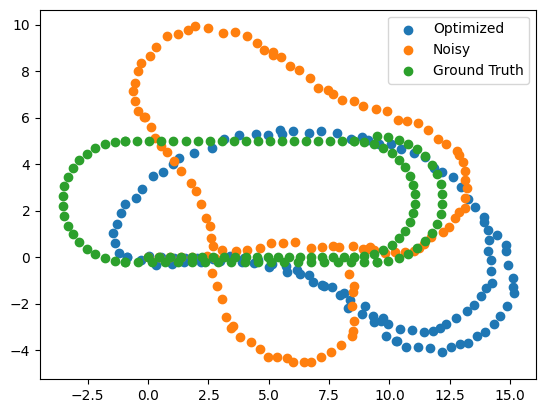

Frob Norm between JAX and our own Jacobian :  8.0488e-07
Iteration :  1  Loss :  372.0030851648852
Frob Norm between JAX and our own Jacobian :  8.0948945e-07
Iteration :  2  Loss :  189.46056795459168
Frob Norm between JAX and our own Jacobian :  6.360739e-07
Iteration :  3  Loss :  92.85040467497237
Frob Norm between JAX and our own Jacobian :  7.152692e-07
Iteration :  4  Loss :  91.82380575812789
Frob Norm between JAX and our own Jacobian :  6.947155e-07
Iteration :  5  Loss :  91.53446309133372
Frob Norm between JAX and our own Jacobian :  7.9468225e-07
Iteration :  6  Loss :  91.48698031364006
Frob Norm between JAX and our own Jacobian :  6.8005716e-07
Iteration :  7  Loss :  91.47389346199273
Frob Norm between JAX and our own Jacobian :  7.0498345e-07
Iteration :  8  Loss :  91.47062349272034
Frob Norm between JAX and our own Jacobian :  7.3690717e-07
Iteration :  9  Loss :  91.46960462161623
Frob Norm between JAX and our own Jacobian :  7.7135377e-07
Iteration :  10  Loss :  91

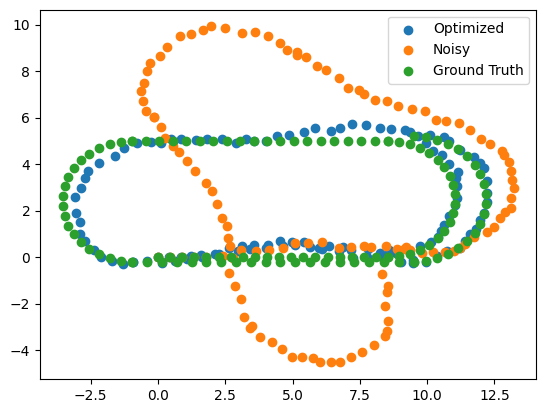

Frob Norm between JAX and our own Jacobian :  7.773324e-07
Iteration :  11  Loss :  91.46922774772939
Frob Norm between JAX and our own Jacobian :  7.29883e-07
Iteration :  12  Loss :  91.46919860516245
Frob Norm between JAX and our own Jacobian :  6.263544e-07
Iteration :  13  Loss :  91.4691796606305
Frob Norm between JAX and our own Jacobian :  7.317862e-07
Iteration :  14  Loss :  91.46917475430392
Frob Norm between JAX and our own Jacobian :  7.176058e-07
Iteration :  15  Loss :  91.46917041882071
Frob Norm between JAX and our own Jacobian :  7.3339976e-07
Iteration :  16  Loss :  91.46916926823728
Frob Norm between JAX and our own Jacobian :  7.564116e-07
Iteration :  17  Loss :  91.46916810642215
Frob Norm between JAX and our own Jacobian :  6.0812545e-07
Iteration :  18  Loss :  91.46916775514183
Frob Norm between JAX and our own Jacobian :  6.9439085e-07
Iteration :  19  Loss :  91.4691673852852
Frob Norm between JAX and our own Jacobian :  7.02061e-07
Iteration :  20  Loss : 

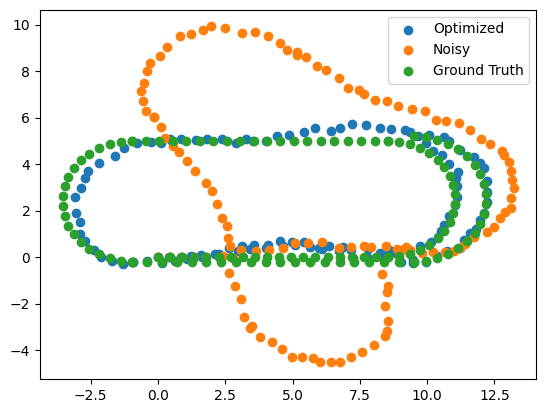

Frob Norm between JAX and our own Jacobian :  7.820057e-07
Iteration :  21  Loss :  91.46916706531354
Frob Norm between JAX and our own Jacobian :  7.9515354e-07
Iteration :  22  Loss :  91.46916695848257
Frob Norm between JAX and our own Jacobian :  7.8559117e-07
Iteration :  23  Loss :  91.46916684926131
Frob Norm between JAX and our own Jacobian :  7.5051247e-07
Iteration :  24  Loss :  91.46916675516957
Frob Norm between JAX and our own Jacobian :  7.6492915e-07
Iteration :  25  Loss :  91.46916666032354
Frob Norm between JAX and our own Jacobian :  7.7604597e-07
Iteration :  26  Loss :  91.46916656951413
Frob Norm between JAX and our own Jacobian :  7.788184e-07
Iteration :  27  Loss :  91.46916647847306
Frob Norm between JAX and our own Jacobian :  7.8021617e-07
Iteration :  28  Loss :  91.46916638850942
Frob Norm between JAX and our own Jacobian :  7.598133e-07
Iteration :  29  Loss :  91.46916629847587


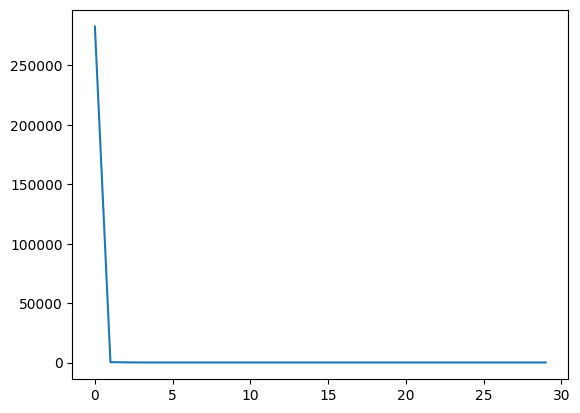

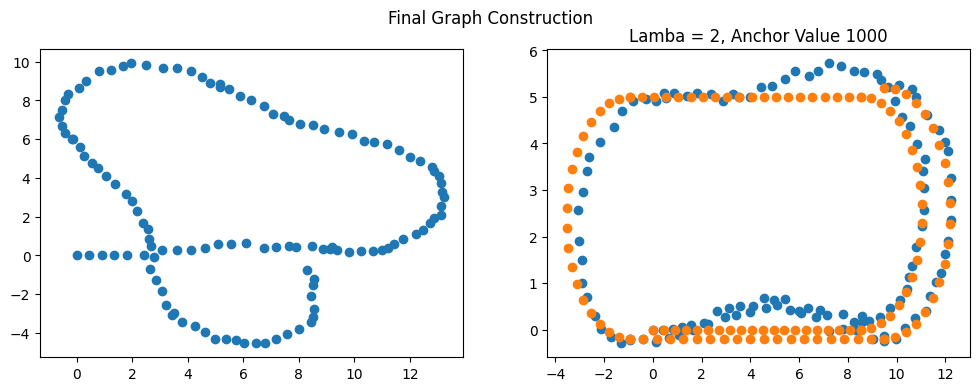

In [105]:
from scipy.linalg import cho_factor, cho_solve
import jax.numpy as jnp
from jax import jacfwd
import numpy as np

def doSLAMGauss(X, Y, T, i1, i2, dX, dY, dT, I, lmda, anchor_val):
    '''
    Input: 
        X: Initial X
        Y: Initial Y
        T: Initial Theta
        i1: First Index in index pair of Constraint
        i2: Second Index in index pair of Constraint
        dX: delta X in Constraint
        dY: delta Y in Constraint
        dT: delta Theta in Constraint
        I: Information Matrix
        
    Output:
        Optimized Graph
    '''
    
    fixIndex = -1
    length = i1.shape[0]
    for i in range(length):
        if np.abs(i2[i] - i1[i]) > 1:
            fixIndex = i
            break

    dX2, loopX = dX[:fixIndex], dX[fixIndex:]
    dY2, loopY = dY[:fixIndex], dY[fixIndex:]
    dT2, loopT = dT[:fixIndex], dT[fixIndex:]
    graph = constructGraph(X, Y, T, dX2, dY2, dT2)
    
    X_gt, Y_gt, _ = readVertex('../data/gt.txt')
    X_gt = np.array(X_gt)
    Y_gt = np.array(Y_gt)
    X_gt -= X_gt[0]
    Y_gt -= Y_gt[0]

    iterations = 30

    lr = 1
    loss_arr = []
    final = graph.copy()
    nodes = len(np.unique(np.concatenate([i1, i2])))
    # final = np.random.randn(nodes, 3)

    def g(x):

        f = jnp.zeros(3 * (i1.shape[0] + 1))
        x = x.reshape(-1, 3)
        for i in range(i1.shape[0]): # iterating thorugh all constraints
            n1 = i1[i]
            n2 = i2[i]
            newX = x[n1, 0] - x[n2, 0] + dX[i] * jnp.cos(x[n1, 2]) - dY[i] * jnp.sin(x[n1, 2])
            newY = x[n1, 1] - x[n2, 1] + dX[i] * jnp.sin(x[n1, 2]) + dY[i] * jnp.cos(x[n1, 2])
            newT = x[n1, 2] + dT[i] - x[n2, 2]
            newT = jnp.tan(newT / 2)
            # print(newT)
            # newT = np.sin(newT / 2)
            # newT = newT * np.sin(4 * np.pi ** 2 / newT)
            f = f.at[3 * i : 3 * (i+1)].set(jnp.array([newX, newY, newT]))
        
        f = f.at[-3:].set(x[0])

        return f

    jac = jacfwd(g)(jnp.array(final).reshape(-1))
    jacob = getJacobian(i1, i2, dX, dY, dT, final)
    print("Frob Norm between JAX and our own Jacobian : ", jnp.linalg.norm(jac - jacob))

    for iteration in range(iterations):

        jacob = getJacobian(i1, i2, dX, dY, dT, final)
        anchor_mat = np.eye(3) * anchor_val
        info = getInformationMatrix(I, anchor_mat)
        hessian = jacob.T @ info @ jacob
        lhs = hessian + lmda * np.diag(hessian)
        precalc = -1 * jacob.T @ info.T
        jac = jacfwd(g)(jnp.array(final).reshape(-1))
        print("Frob Norm between JAX and our own Jacobian : ", jnp.linalg.norm(jac - jacob))
        
        f = np.empty(3 * (i1.shape[0] + 1))
        for i in range(i1.shape[0]): # iterating thorugh all constraints
            n1 = i1[i]
            n2 = i2[i]
            newX = final[n1, 0] - final[n2, 0] + dX[i] * np.cos(final[n1, 2]) - dY[i] * np.sin(final[n1, 2])
            newY = final[n1, 1] - final[n2, 1] + dX[i] * np.sin(final[n1, 2]) + dY[i] * np.cos(final[n1, 2])
            newT = final[n1, 2] + dT[i] - final[n2, 2]
            # newT = np.sin(newT / 2)
            newT = np.tan(newT / 2)
            # newT = newT * np.sin(4 * np.pi ** 2 / newT)
            f[3 * i : 3 * (i+1)] = np.array([newX, newY, newT])
            
        f[-3:] = final[0]
        rhs = precalc @ f
        # c, low = cho_factor(lhs)
        # dx = cho_solve((c, low), rhs)
        dx = np.linalg.solve(lhs, rhs)
        final += lr * dx.reshape(-1, 3)
        
        loss = f.T @ info @ f / 2
        print("Iteration : ", iteration, " Loss : ", loss)
        if(iteration % 10 == 0):
            plt.scatter(final[:,0], final[:,1], label = "Optimized")
            plt.scatter(graph[:,0], graph[:,1], label = "Noisy")
            plt.scatter(X_gt, Y_gt, label = "Ground Truth")
            plt.legend()
            plt.show()
        loss_arr.append(loss)
            
    # draw(final[:, 0], final[:, 1], final[:, 2])
    new_loss_arr = np.array(loss_arr)
    plt.plot(new_loss_arr)
    plt.show()

    _, ax = plt.subplots(1, 2, figsize=(12, 4))
    plt.suptitle("Final Graph Construction")
    ax[0].scatter(graph[:,0], graph[:,1])
    ax[1].scatter(final[:,0], final[:,1])
    ax[1].scatter(X_gt, Y_gt)
    plt.title(f"Lamba = {lmda}, Anchor Value {anchor_val}")
    # draw(final[:, 0], final[:, 1], final[:, 2])
    # for k in range(final.shape[0]):
    #     plt.scatter(final[:k, 0], final[:k, 1])
    #     plt.show()
        
    plt.show()
    return final, loss_arr
        
X, Y, T = readVertex("../data/edges.txt")[:, 0]

I, i1, i2, dX, dY, dT = readEdge("../data/edges.txt")

nodes = np.unique(np.concatenate([i1, i2]))
final = np.random.randn(len(nodes), 3)


optimizedGraph, loss = doSLAMGauss(X, Y, T, i1, i2, dX, dY, dT, I, 2, 1000)

8.805108e-07


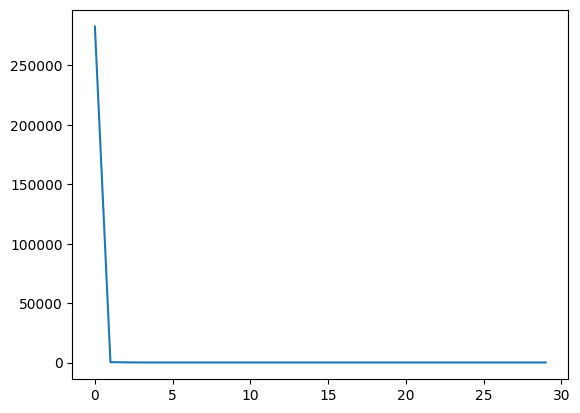

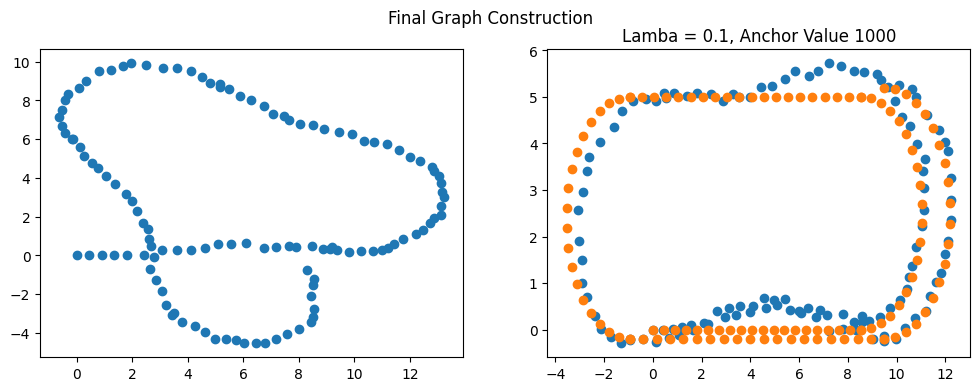

8.805108e-07


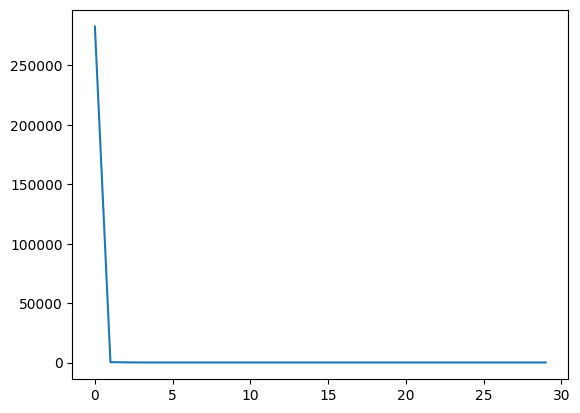

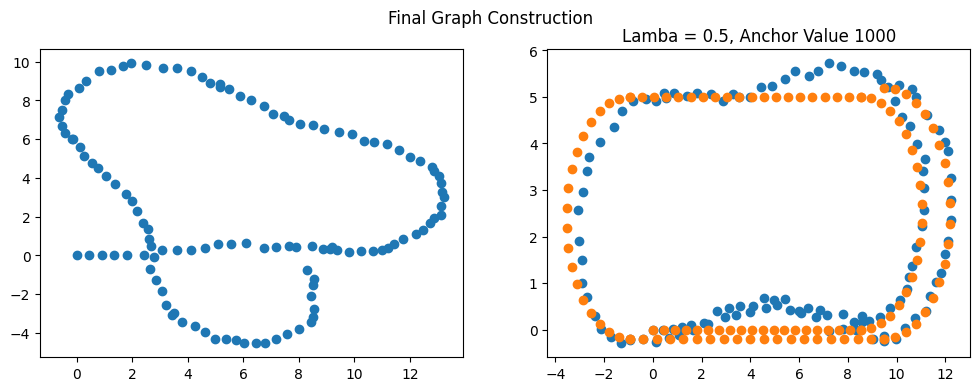

8.805108e-07


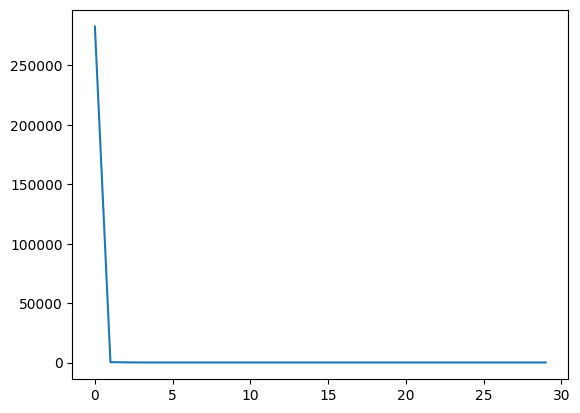

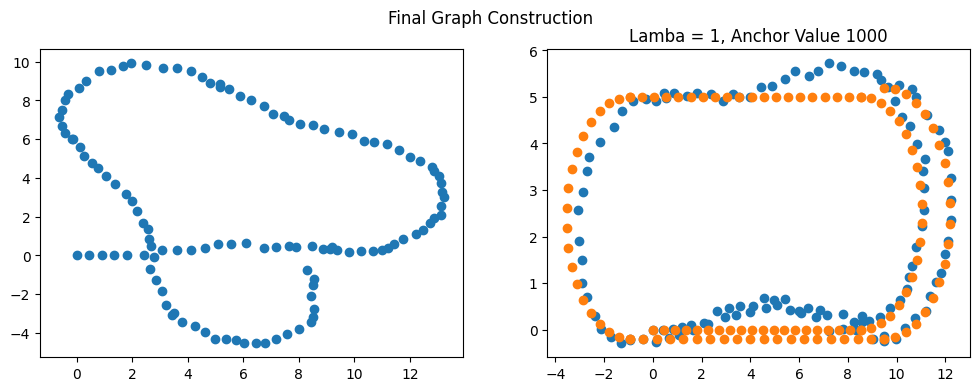

8.805108e-07


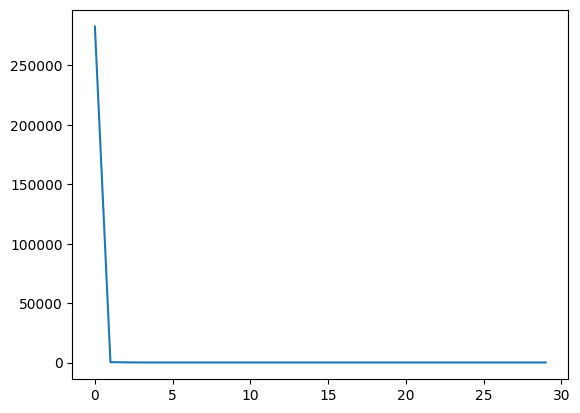

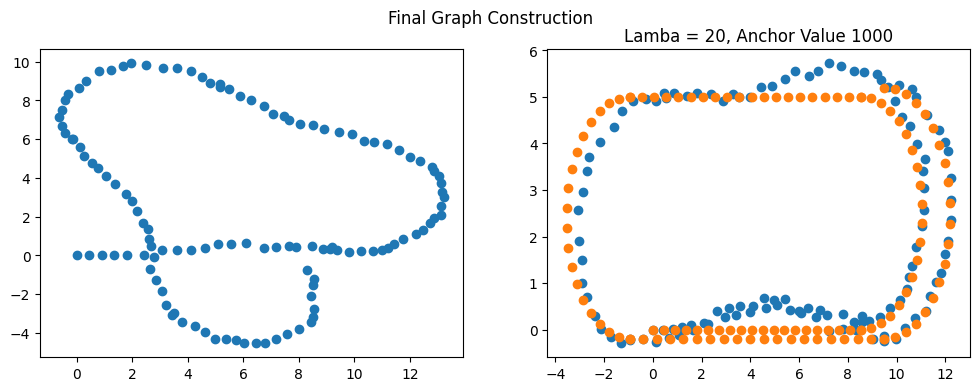

8.805108e-07


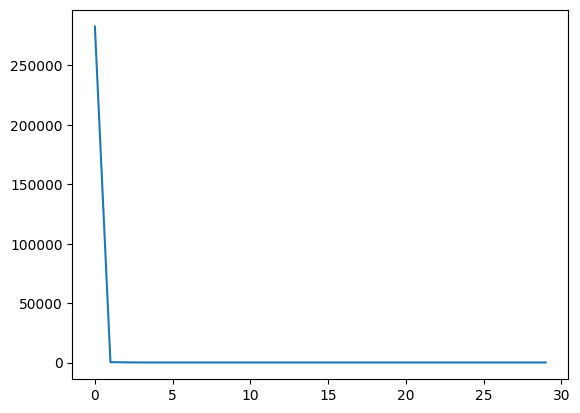

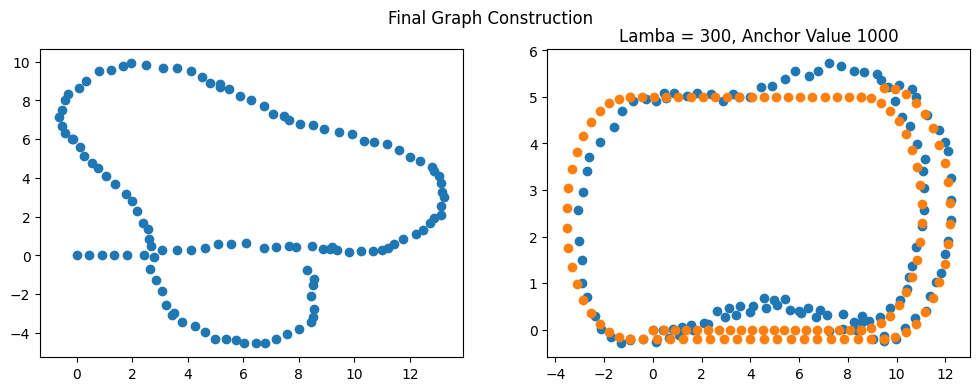

In [85]:
lamdas = [0.1, 0.5, 1, 20, 300]
for i in lamdas:
    optimizedGraph, loss = doSLAMGauss(X, Y, T, i1, i2, dX, dY, dT, I, i, 1000)


8.805108e-07


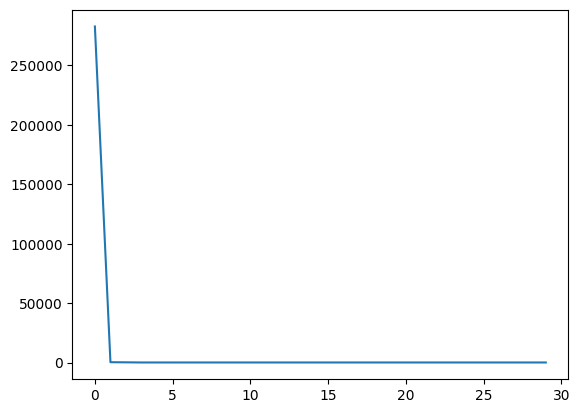

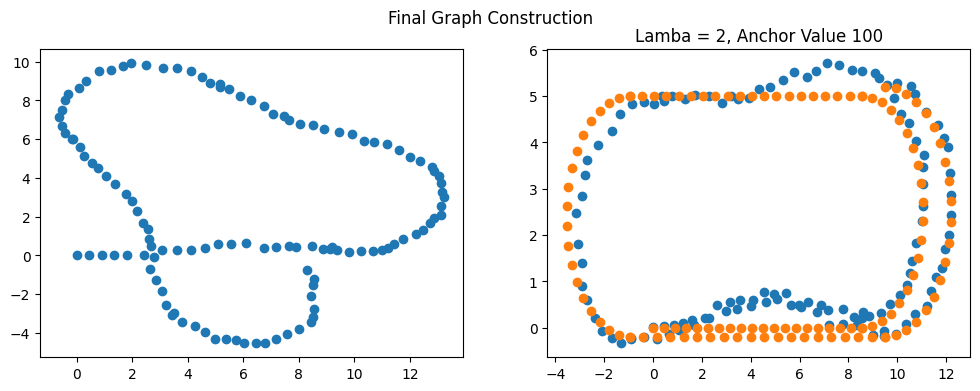

8.805108e-07


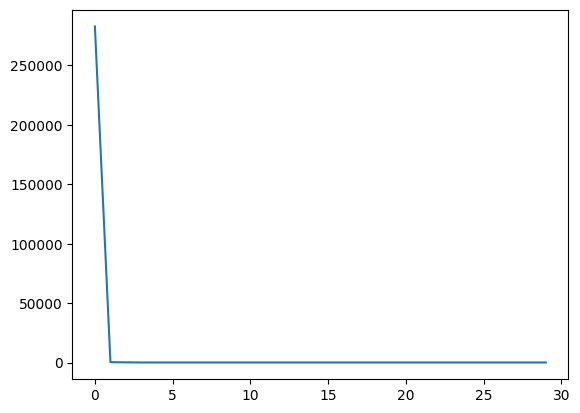

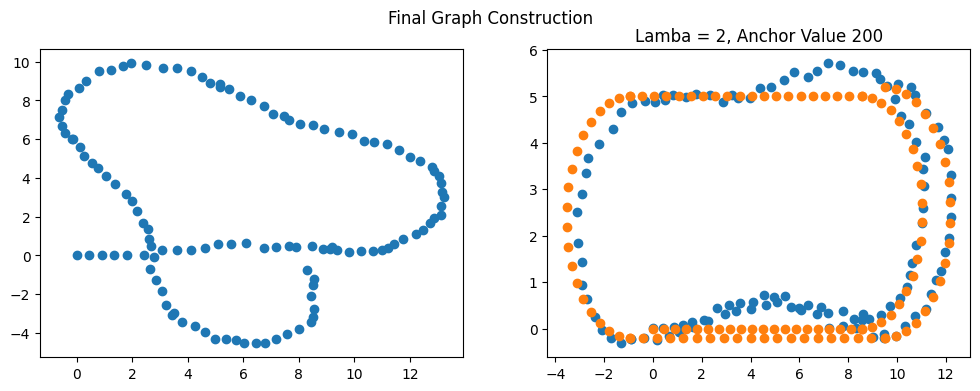

8.805108e-07


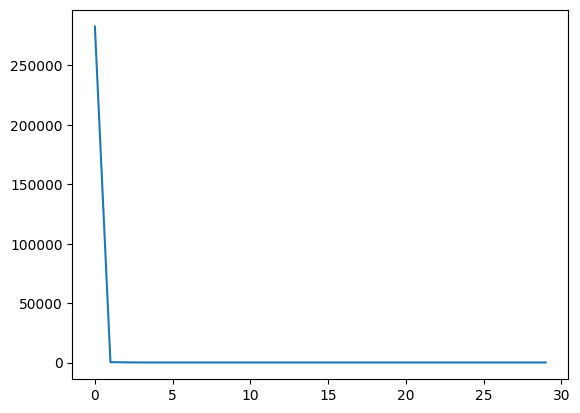

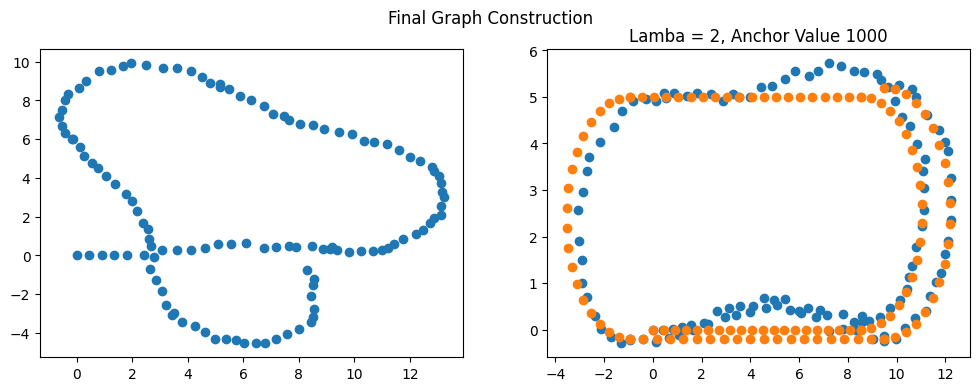

8.805108e-07


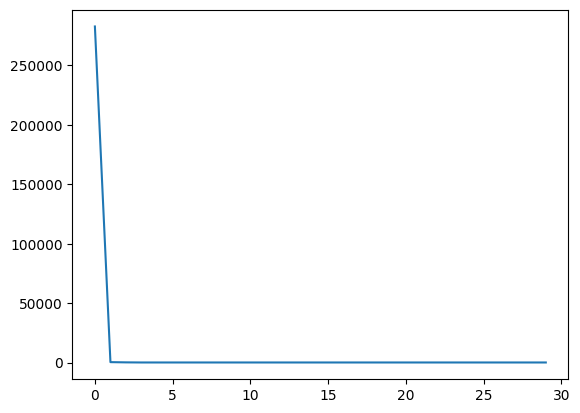

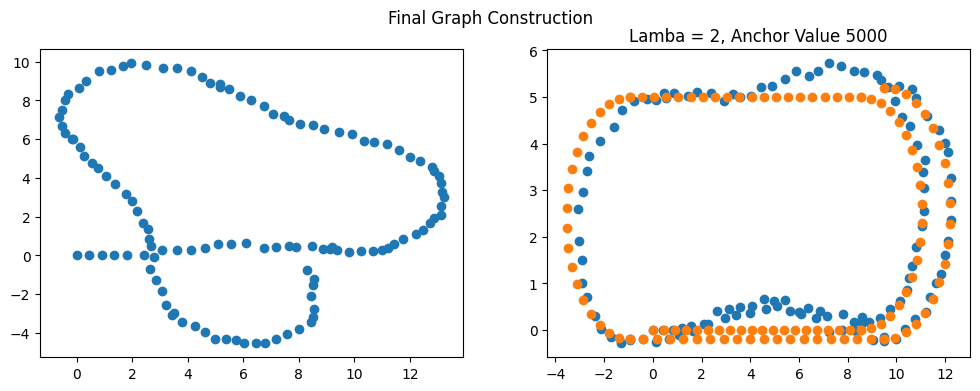

8.805108e-07


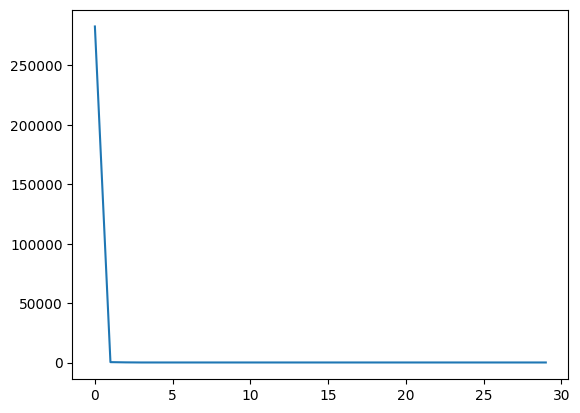

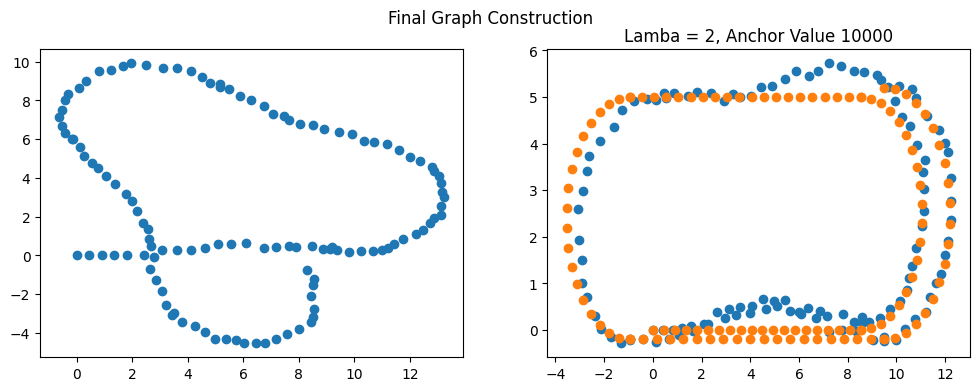

In [86]:
anc = [100, 200, 1000, 5000, 10000]
for i in anc:
    optimizedGraph, loss = doSLAMGauss(X, Y, T, i1, i2, dX, dY, dT, I, 2, i)

In [324]:
print(optimizedGraph[0])
print(optimizedGraph[1])
print(optimizedGraph[2])
print(optimizedGraph[3])
print(optimizedGraph[4])
print(optimizedGraph[80])


[-7.90716883e-19  6.29427435e-18  2.28660480e-02]
[0.41615188 0.00929359 0.07620332]
[0.83111546 0.04255667 0.12383353]
[1.19885311 0.1057935  0.17024458]
[1.56353119 0.18968808 0.17800842]
[-0.92108564 -0.22095769 -6.1945717 ]


### Part 3

- Write about the residuals you computed, its structure and shape. Also explain the structure of the Jacobian and its shape (Express the shape in terms of the number of vertices, loop constraints, and such, not exact numbers). 
- Write about the optimization process and any observations using intermediate plots and such. 

The shape of the residual is 3 * (e + 1), where e is the number of edges in the pose graph. The number of edges is equal to the number of odometry edges + number of loop closure edges + 1 (for the anchor edge). The residual is a vector with 3 elements per 

The jacobian is of the shape 3 (e + 1) x 3n, where e is the number of edges and n is the number of vertices.
The jacobian is a sparse matrix with 3 non-zero elements per row.

We have observed from the loss curve that the loss decreases rapidly in the first few iterations itself.


We have tried with many funcitons for the angle update, as we cant just take the regular differenc eof the angles, as this will only penalize higher values, but higher values could be rotationally same. Hence we took a periodic function which penalized angles correctly. We tried with many funcitons like np.sin, sinc, x * sin(1/x), but we finally chose np.tan as this was penalizing the wrong ones the most.

### Part 4

Write the final optimised trajectory as a g2o file. You can do this alongside any of the earlier parts.

In [46]:
writeG2O(optimizedGraph, "../data/output.g2o")

6.372515e-05


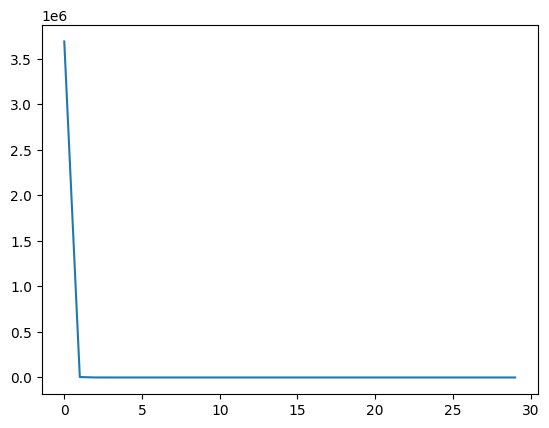

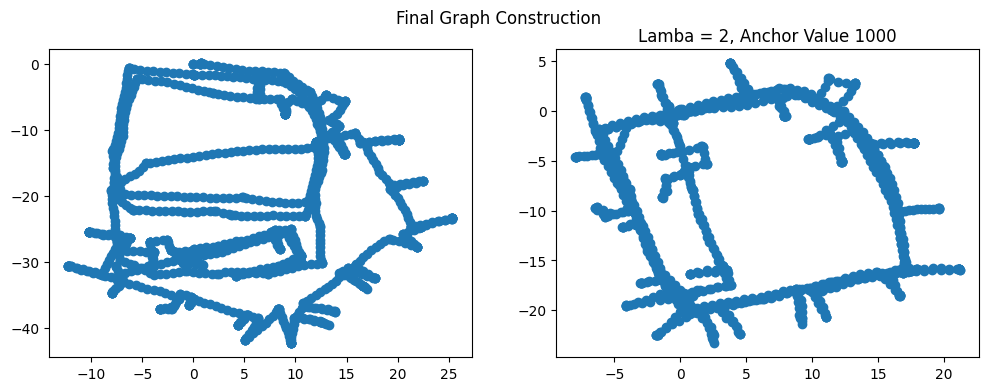

In [89]:
X, Y, T = readVertex("../data/intel.g2o")[:, 0]

I, i1, i2, dX, dY, dT = readEdge("../data/intel.g2o")

nodes = np.unique(np.concatenate([i1, i2]))
final = np.random.randn(len(nodes), 3)


optimizedGraph, loss = doSLAMGauss(X, Y, T, i1, i2, dX, dY, dT, I, 2, 1000)